<a href="https://colab.research.google.com/github/shekhar-d/cds/blob/main/Group10_M2_NB_MiniProject_3_Dementia_prediction_SVM_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini-Project: Dementia prediction using SVM

## Problem Statement

Prediction of Dementia using an SVM model on brain MRI features

## Learning Objectives

At the end of the mini-project, you will be able to :

* perform data exploration, preprocessing and visualization
* implement SVM Classifier on the data
* explore various parameters of SVM classifier and implement OneVsOne classifier
* calculate the metrics and plot the roc_curve

## Information

**About Dementia**

Dementia is a general term for loss of memory and other mental abilities severe enough to interfere with daily life. It is caused by physical changes in the brain. Alzheimer's is the most common type of dementia, but there are many kinds.

**Brain Imaging via magnetic resonance imaging (MRI) and Machine Learning**

* MRI is used for the evaluation of patients with suspected Alzheimer's disease
* MRIs detect both, local and generalized shrinkage of brain tissue.
* MRI features predict the rate of decline of AD and may guide therapy in the future
* Using machine learning on MRI features could help in automatedly and accurately predicting the progress of a patient from mild cognitive impairment to dementia

To understand the basics of MRI technique, you could refer [here](https://case.edu/med/neurology/NR/MRI%20Basics.htm)

## Dataset

The dataset chosen for this mini-project is [OASIS - Longitudinal brain MRI Dataset](https://www.oasis-brains.org/). This dataset consists of a longitudinal MRI collection of 150 subjects aged 60 to 96. Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 72 of the subjects were characterized as nondemented throughout the study. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease. Another 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit.

**Dataset fields:**

* Subject ID - Subject Identification
* MRI ID - MRI Exam Identification
* Group - Target variable with 3 labels ('NonDemented', 'Demented', 'Converted')
* Visit - Visit order
* MR Delay - MR Delay Time (Contrast)
* M/F - Male or Female
* Hand - Unique value 'R'
* MMSE - Mini-Mental State Examination score (range is from 0 = worst to 30 = best)
* CDR - Clinical Dementia Rating (0 = no dementia, 0.5 = very mild AD, 1 = mild AD, 2 = moderate AD)
* Derived anatomic volumes
* eTIV - Estimated total intracranial volume, mm3
* nWBV - Normalized whole-brain volume, expressed as a percent of all voxels in the atlas-masked image that are labeled as gray or white matter by the automated tissue segmentation process
* ASF - Atlas scaling factor (unitless). A computed scaling factor that transforms native-space brain and skull to the atlas target (i.e., the determinant of the transform matrix)

For learning more on building a machine learning model to predict dementia using SVM, refer [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7408873/).

## Grading = 10 Points

In [ ]:
#@title Download the dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/oasis_longitudinal.csv
print("Data downloaded successfully!")

Data downloaded successfully!


### Import required packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import math
# sklearn imports
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

### Load the dataset

In [ ]:
# YOUR CODE HERE
df = pd.read_csv('oasis_longitudinal.csv')

In [ ]:
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [ ]:
# Picking one row per subject (latest visit only)
df['rn'] = df.sort_values(['Visit'], ascending=[False]) \
             .groupby(['Subject ID']) \
             .cumcount() + 1

In [ ]:
df.rn.value_counts()

2    150
1    150
3     56
4     13
5      4
Name: rn, dtype: int64

In [ ]:
df_lv = df[df.rn==1]

In [ ]:
df_lv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 372
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  150 non-null    object 
 1   MRI ID      150 non-null    object 
 2   Group       150 non-null    object 
 3   Visit       150 non-null    int64  
 4   MR Delay    150 non-null    int64  
 5   M/F         150 non-null    object 
 6   Hand        150 non-null    object 
 7   Age         150 non-null    int64  
 8   EDUC        150 non-null    int64  
 9   SES         142 non-null    float64
 10  MMSE        149 non-null    float64
 11  CDR         150 non-null    float64
 12  eTIV        150 non-null    int64  
 13  nWBV        150 non-null    float64
 14  ASF         150 non-null    float64
 15  rn          150 non-null    int64  
dtypes: float64(5), int64(6), object(5)
memory usage: 19.9+ KB


In [ ]:
df_lv['SES'].value_counts(), df_lv['MMSE'].value_counts()

(2.0    42
 3.0    34
 1.0    33
 4.0    30
 5.0     3
 Name: SES, dtype: int64, 30.0    41
 29.0    29
 28.0    20
 27.0    17
 26.0     7
 21.0     5
 25.0     5
 22.0     5
 20.0     4
 17.0     4
 23.0     3
 24.0     3
 18.0     2
 16.0     2
 15.0     1
 4.0      1
 Name: MMSE, dtype: int64)

In [ ]:
df_lv = df_lv.dropna()

In [ ]:
df_lv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142 entries, 1 to 372
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  142 non-null    object 
 1   MRI ID      142 non-null    object 
 2   Group       142 non-null    object 
 3   Visit       142 non-null    int64  
 4   MR Delay    142 non-null    int64  
 5   M/F         142 non-null    object 
 6   Hand        142 non-null    object 
 7   Age         142 non-null    int64  
 8   EDUC        142 non-null    int64  
 9   SES         142 non-null    float64
 10  MMSE        142 non-null    float64
 11  CDR         142 non-null    float64
 12  eTIV        142 non-null    int64  
 13  nWBV        142 non-null    float64
 14  ASF         142 non-null    float64
 15  rn          142 non-null    int64  
dtypes: float64(5), int64(6), object(5)
memory usage: 18.9+ KB


In [ ]:
df_lv.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,rn
count,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.000000,142.0
mean,2.528169,1076.084507,78.401408,14.647887,2.492958,26.852113,0.334507,1486.232394,0.723056,1.197408,1.0
std,0.787254,543.590343,7.857832,2.895820,1.128273,4.200552,0.424105,179.544485,0.039160,0.139912,0.0
min,2.000000,365.000000,62.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000,1.0
25%,2.000000,653.750000,73.000000,12.000000,2.000000,26.000000,0.000000,1351.500000,0.692000,1.119250,1.0
50%,2.000000,850.000000,78.000000,15.000000,2.000000,28.000000,0.000000,1478.500000,0.722500,1.187500,1.0
75%,3.000000,1444.000000,84.000000,16.000000,3.000000,30.000000,0.500000,1567.250000,0.748000,1.298500,1.0
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.827000,1.587000,1.0


In [ ]:
print(pd.crosstab(df_lv['Visit'], df_lv['Group'], margins = True))

Group  Converted  Demented  Nondemented  All
Visit                                       
2              6        43           38   87
3              6        11           24   41
4              1         1            6    8
5              1         1            4    6
All           14        56           72  142


### Pre-processing and Data Engineering (2 points)

#### Remove unwanted columns

In [ ]:
df_lv.columns

Index(['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F', 'Hand',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'rn'],
      dtype='object')

In [ ]:
# YOUR CODE HERE
wanted_columns = ['Group', 'Visit', 'MR Delay', 'M/F',
       'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']

df1 = df_lv[wanted_columns]
df2 = df[wanted_columns]

In [ ]:
df1.head()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
1,Nondemented,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
6,Nondemented,2,538,F,90,18,3.0,27.0,0.0,1200,0.718,1.462
9,Nondemented,3,1603,M,85,12,4.0,30.0,0.0,1699,0.705,1.033
14,Nondemented,2,742,F,95,14,2.0,29.0,0.0,1257,0.703,1.396
16,Demented,2,576,M,69,12,2.0,24.0,0.5,1480,0.791,1.186


In [ ]:
df1.Group.unique()

array(['Nondemented', 'Demented', 'Converted'], dtype=object)

In [ ]:
def converter(Group):
    if Group == 'Nondemented':
        return 0
    elif Group == 'Demented':
       return 1
    else:
        return 2

In [ ]:
df1['Group'] = df1['Group'].apply(converter)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df1.head()

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
1,0,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
6,0,2,538,F,90,18,3.0,27.0,0.0,1200,0.718,1.462
9,0,3,1603,M,85,12,4.0,30.0,0.0,1699,0.705,1.033
14,0,2,742,F,95,14,2.0,29.0,0.0,1257,0.703,1.396
16,1,2,576,M,69,12,2.0,24.0,0.5,1480,0.791,1.186


In [ ]:
#df2['Group'] = df2['Group'].apply(converter)

#### Encode categorical features into numeric

In [ ]:
# Convert M/F to numeric using OnehotEncoding

In [ ]:
#from pandas.core.dtypes.dtypes import CategoricalDtype

In [ ]:
'''categorical_columns = ['M/F']
cat = CategoricalDtype()

#df1['Group'] = df1['Group'].astype(cat)
df2['M/F'] = df2['M/F'].astype(cat)'''

"categorical_columns = ['M/F']\ncat = CategoricalDtype()\n\n#df1['Group'] = df1['Group'].astype(cat)\ndf2['M/F'] = df2['M/F'].astype(cat)"

In [ ]:
'''df3 = pd.get_dummies(df2, drop_first='True')
df3.head()'''

"df3 = pd.get_dummies(df2, drop_first='True')\ndf3.head()"

#### Handle the null values by removing or replacing

In [ ]:
#df3 = df3.dropna()

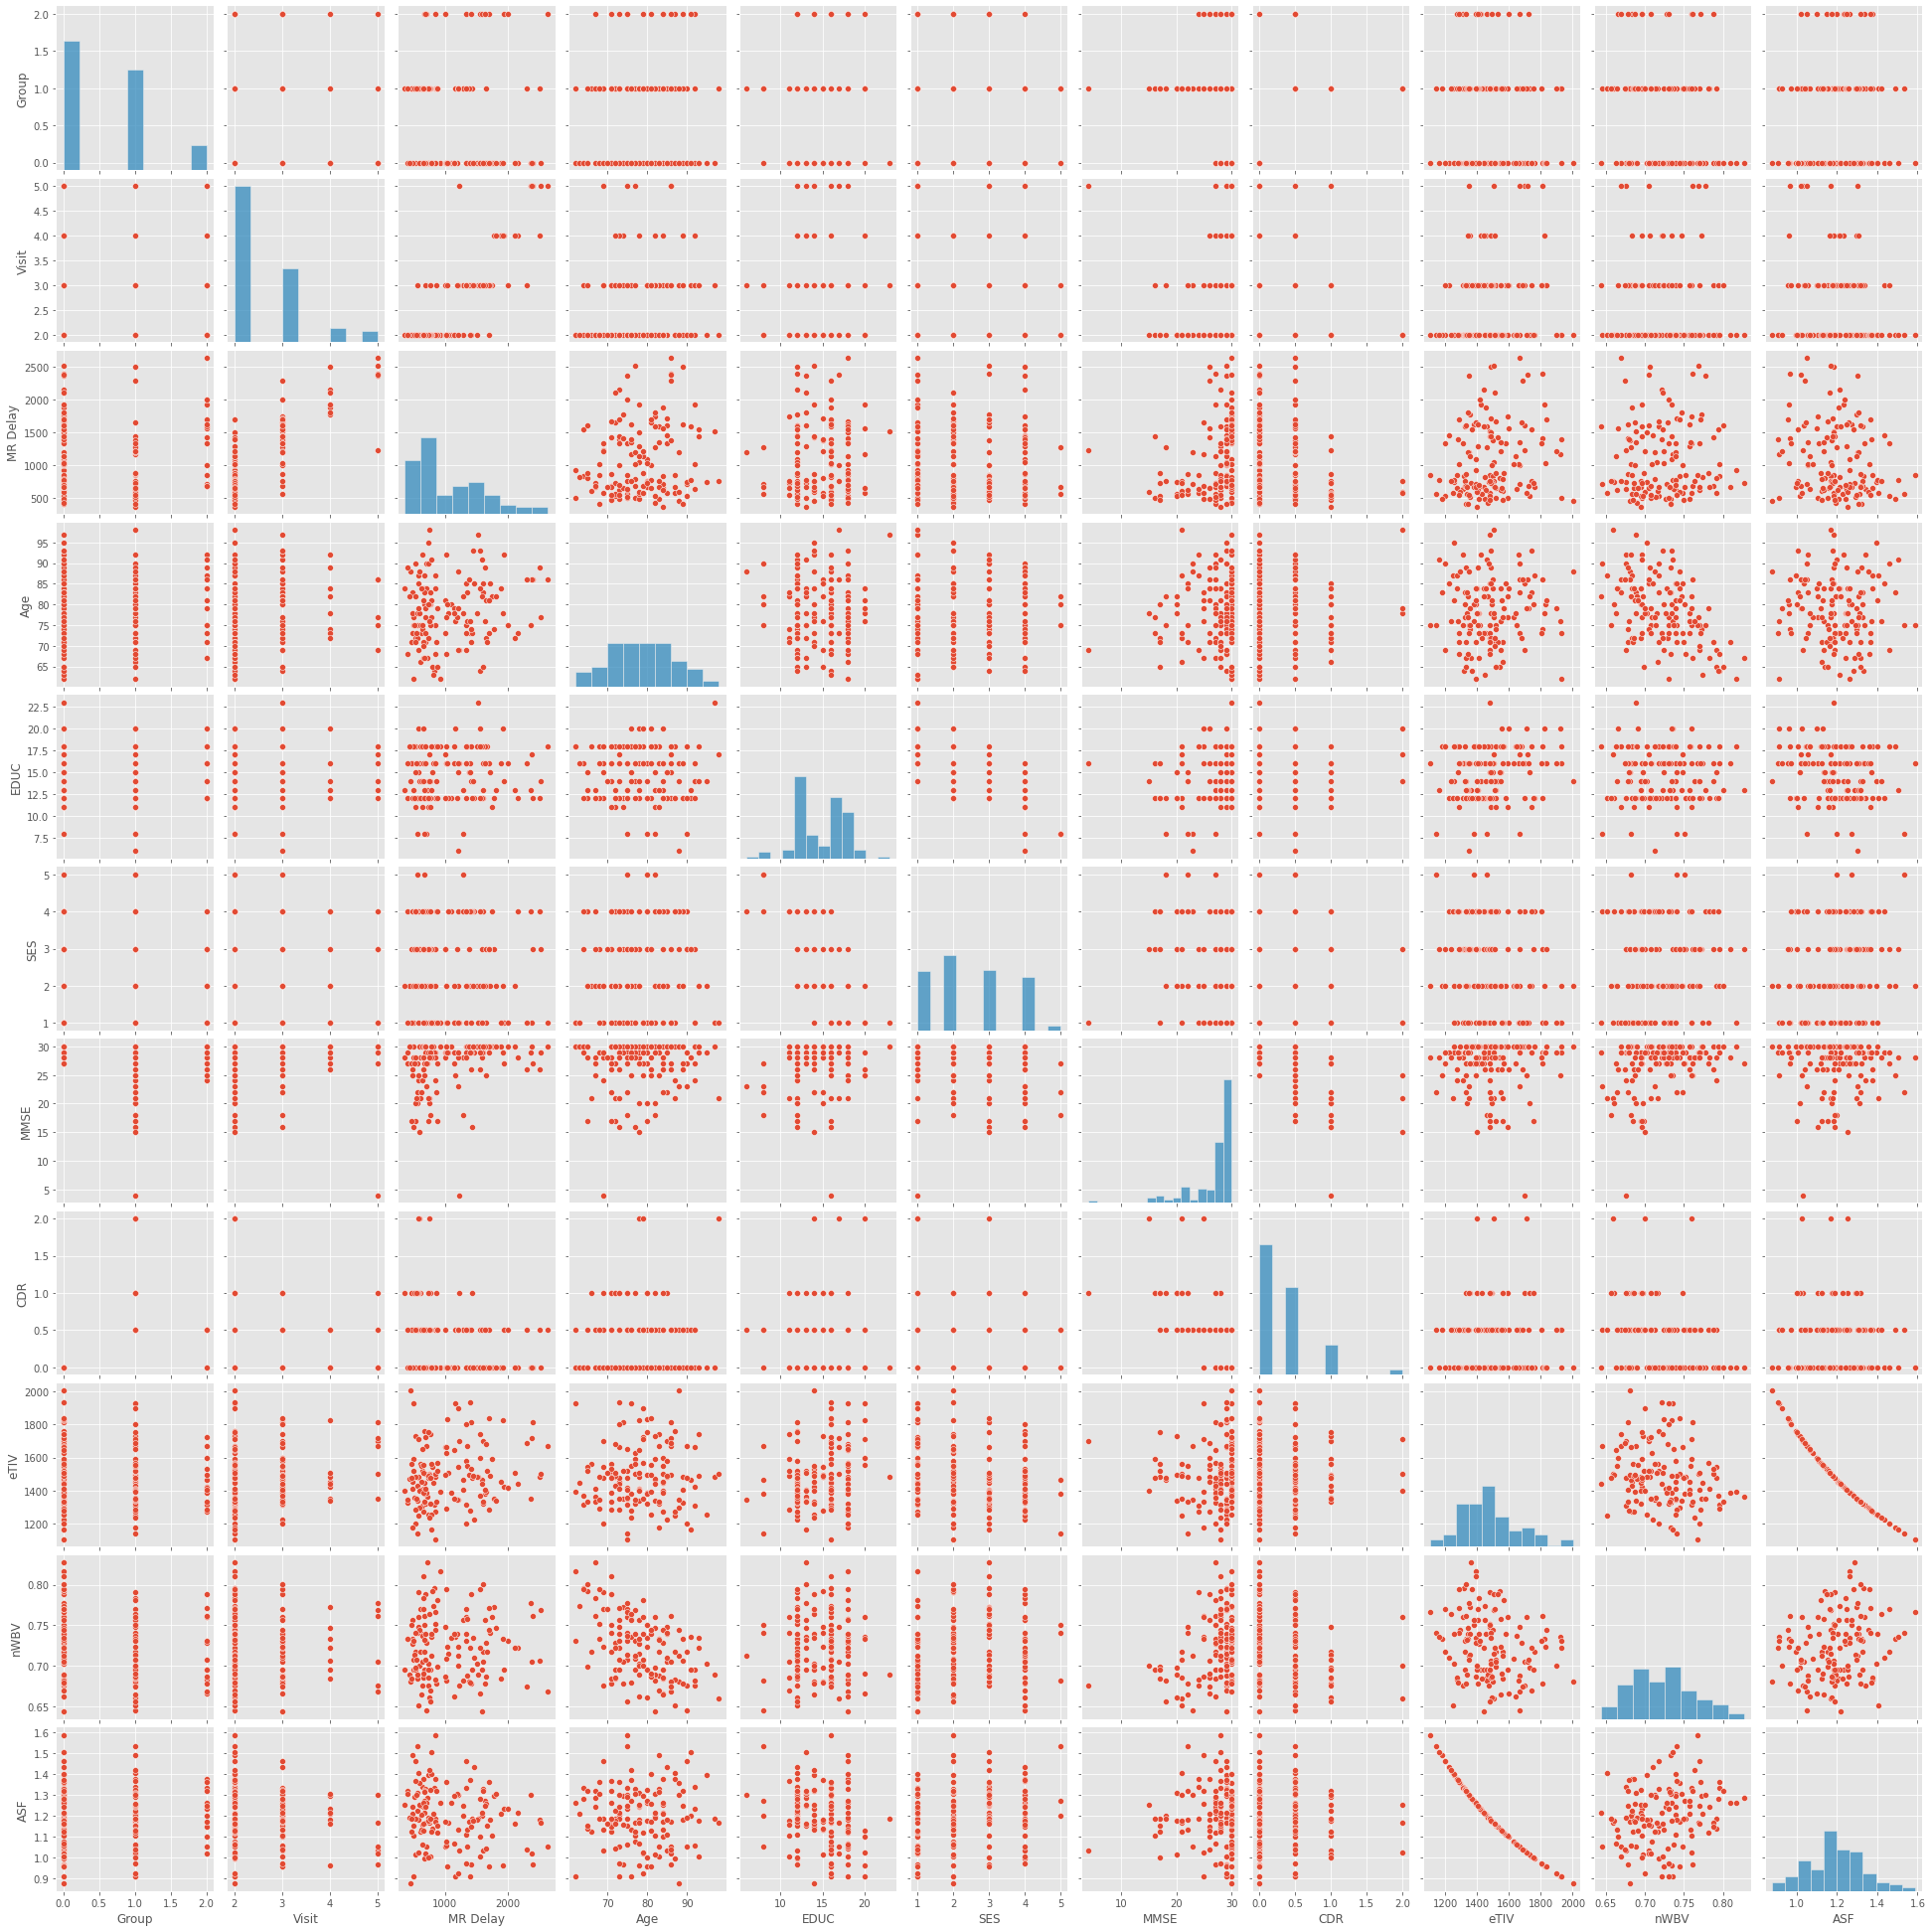

In [ ]:
plt.style.use('ggplot')
sns.pairplot(df1)

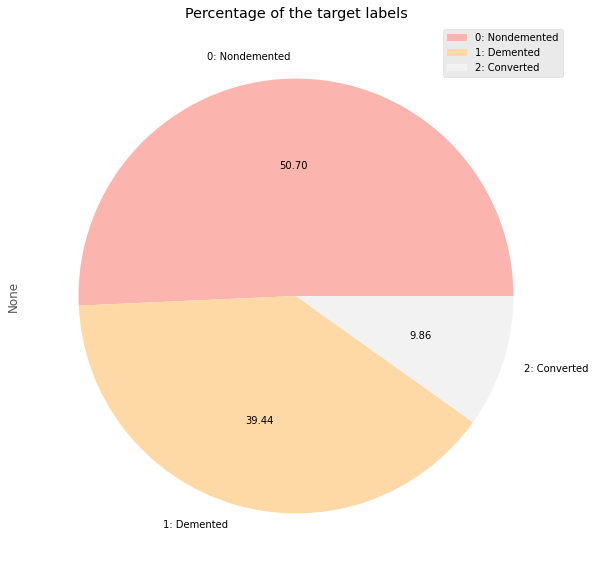

In [ ]:
labels = [r'0: Nondemented', r'1: Demented', r'2: Converted']
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Percentage of the target labels")
df1.groupby('Group').size().plot(kind='pie', autopct='%.2f',labels=labels, legend = True, colormap='Pastel1' );

In [ ]:
'''labels = [r'0: Nondemented', r'1: Demented', r'2: Converted']
fig, ax = plt.subplots(figsize=(20,10))
ax.set_title("Percentage of the target labels")
df3.groupby('Group').size().plot(kind='pie', autopct='%.2f',labels=labels, legend = True, colormap='Pastel2' );'''

'labels = [r\'0: Nondemented\', r\'1: Demented\', r\'2: Converted\']\nfig, ax = plt.subplots(figsize=(20,10))\nax.set_title("Percentage of the target labels")\ndf3.groupby(\'Group\').size().plot(kind=\'pie\', autopct=\'%.2f\',labels=labels, legend = True, colormap=\'Pastel2\' );'

#### Identify feature and target and split it into train test

In [ ]:
# YOUR CODE HERE
X = df1.drop(['Group'], axis = 1)                  
y = df1[['Group']]                

In [ ]:
X.head()

,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
1,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876
6,2,538,F,90,18,3.0,27.0,0.0,1200,0.718,1.462
9,3,1603,M,85,12,4.0,30.0,0.0,1699,0.705,1.033
14,2,742,F,95,14,2.0,29.0,0.0,1257,0.703,1.396
16,2,576,M,69,12,2.0,24.0,0.5,1480,0.791,1.186


In [ ]:
y.value_counts()

Group
0        72
1        56
2        14
dtype: int64

In [ ]:
y.shape

(142, 1)

In [ ]:
# Split after onehot encoding of M/F

### EDA &  Visualization (1 point)

#### Plot the distribution of all the variables using a histogram

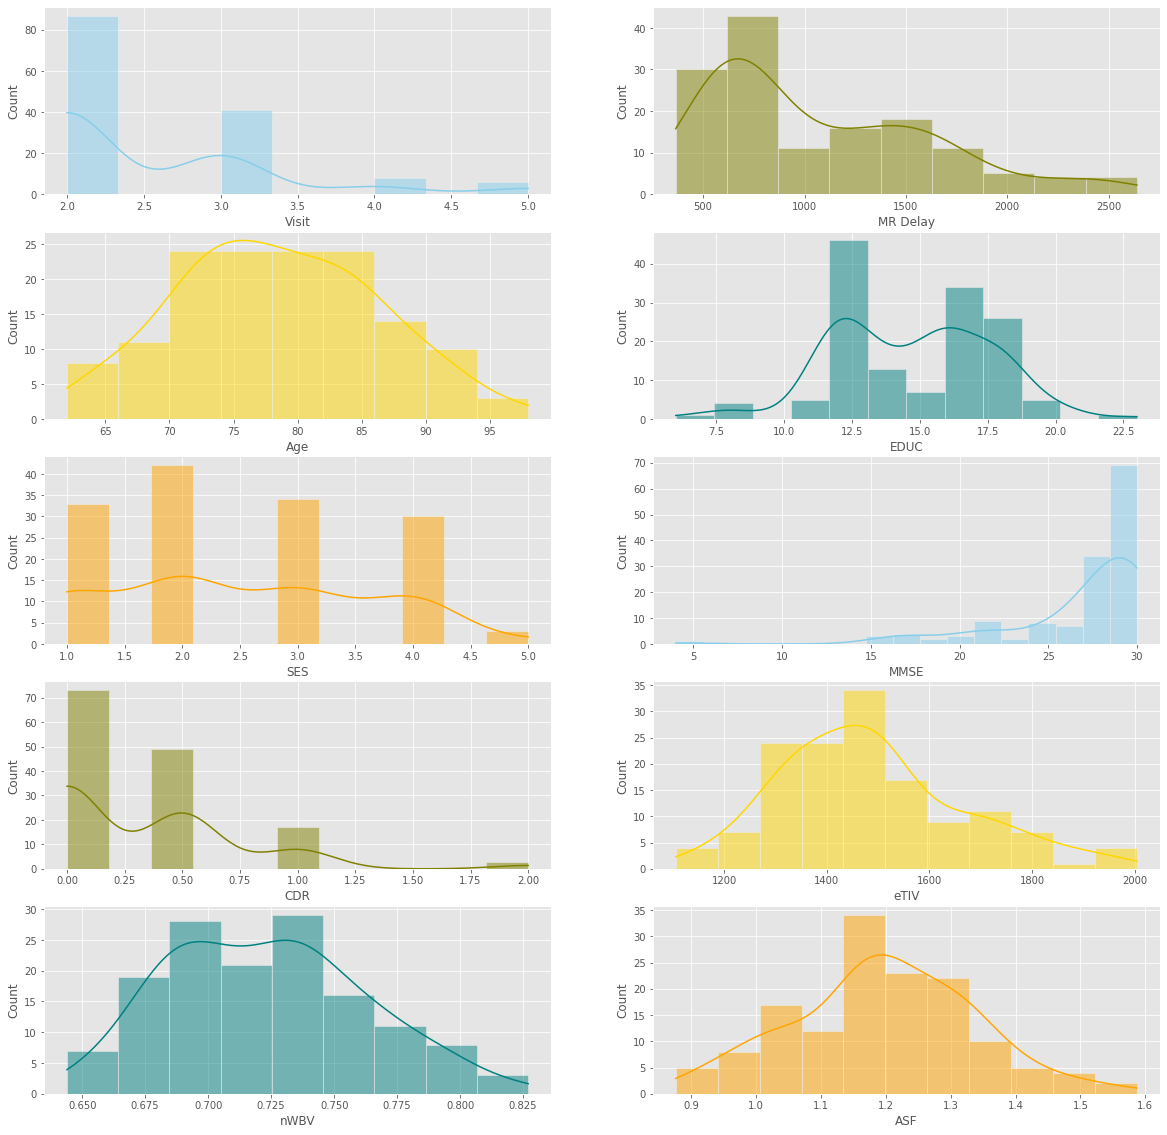

In [ ]:
# YOUR CODE HERE
fig, axs = plt.subplots(5, 2, figsize=(20, 20))

sns.histplot(data=df1, x="Visit", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=df1, x="MR Delay", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=df1, x="Age", kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=df1, x="EDUC", kde=True, color="teal", ax=axs[1, 1])
sns.histplot(data=df1, x="SES", kde=True, color="orange", ax=axs[2, 0])
sns.histplot(data=df1, x="MMSE", kde=True, color="skyblue", ax=axs[2, 1])
sns.histplot(data=df1, x="CDR", kde=True, color="olive", ax=axs[3, 0])
sns.histplot(data=df1, x="eTIV", kde=True, color="gold", ax=axs[3, 1])
sns.histplot(data=df1, x="nWBV", kde=True, color="teal", ax=axs[4, 0])
sns.histplot(data=df1, x="ASF", kde=True, color="orange", ax=axs[4, 1])

plt.show()

#### Visualize the frequency of Age

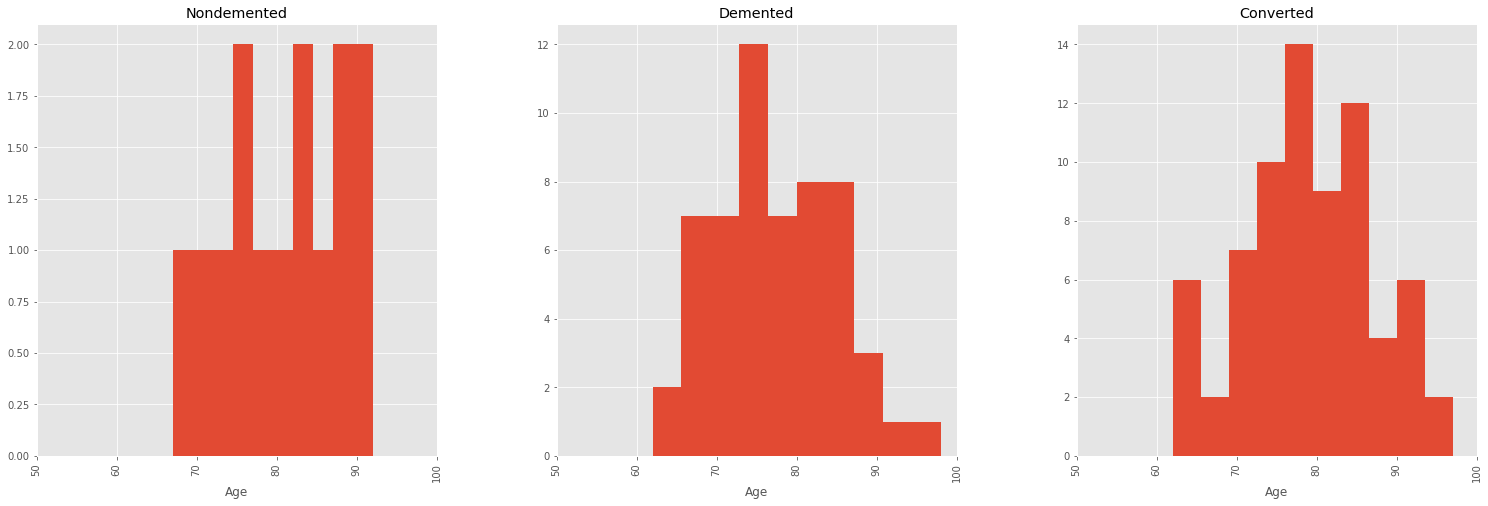

In [ ]:
# YOUR CODE HERE

age_hist = df1['Age'].hist(by=df['Group'], layout=(1,3), figsize = (25,8))
age_hist[0].set_xlim((50,100))
age_hist[0].set_title('Nondemented')
age_hist[0].set_xlabel('Age')
age_hist[1].set_xlim((50,100))
age_hist[1].set_title('Demented')
age_hist[1].set_xlabel('Age')
age_hist[2].set_xlim((50,100))
age_hist[2].set_title('Converted')
age_hist[2].set_xlabel('Age')
plt.show()

#### How many people have Alzheimer? Visualize with an appropriate plot

the same person visits two or more times; extract the single visit data and plot

**Hint**: Visit = 1

In [ ]:
# Ambiguous question - need to get clarity on this

In [ ]:
df1.Visit.value_counts()

2    87
3    41
4     8
5     6
Name: Visit, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


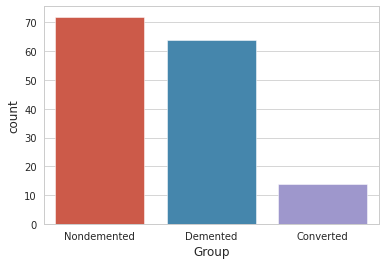

In [ ]:
# YOUR CODE HERE
sns.set_style("whitegrid")
ex_df = df[df['Visit'] == 1]
sns.countplot(ex_df.Group);

#### Calculate the correlation of features and plot the heatmap

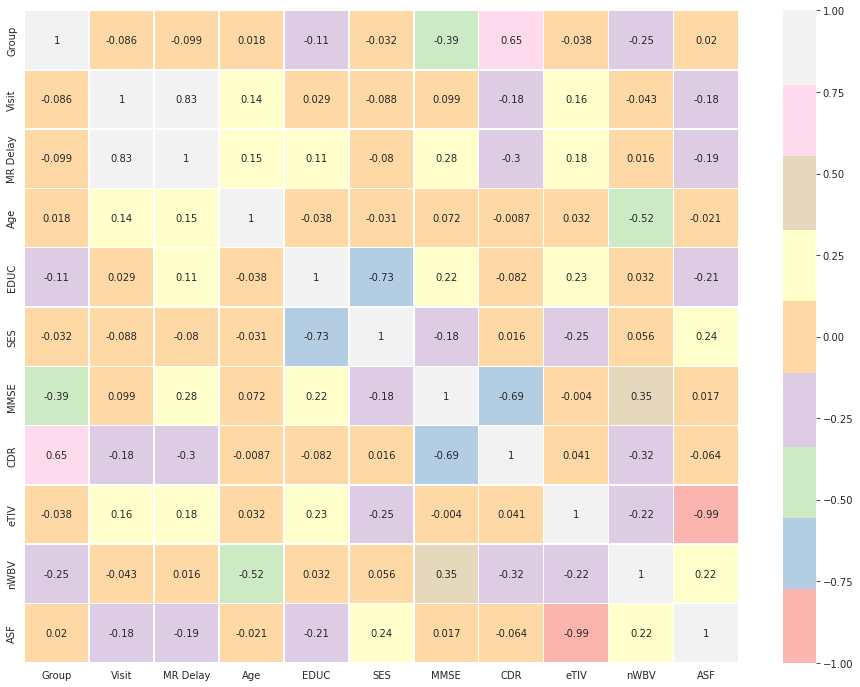

In [ ]:
# YOUR CODE HERE
plt.figure(figsize=(16, 12))
sns.heatmap(df1.corr(), annot=True, linewidth=0.5, center=0, vmin = -1, vmax= 1, cmap = 'Pastel1')
plt.show()

### Model training and evaluation (4 points)

**Hint:** SVM model from sklearn

In [ ]:
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions   

In [ ]:
from sklearn.svm import SVC, SVR, LinearSVC                               # importing Support vector classifier, Support Vector Regressor, LinearSVC  
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline   

In [ ]:
df1.columns

Index(['Group', 'Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE',
       'CDR', 'eTIV', 'nWBV', 'ASF'],
      dtype='object')

In [ ]:
# Instantiate encoder/scaler
scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns  = scaler.fit_transform(X[['Visit', 'MR Delay', 'Age', 'EDUC', 'SES', 'MMSE',
       'CDR', 'eTIV', 'nWBV', 'ASF']]) 
encoded_columns =  ohe.fit_transform(X[['M/F']])

# Concatenate (Column-Bind) Processed Columns Back Together
processed_data = np.concatenate([scaled_columns, encoded_columns], axis=1)
X_train, X_test, y_train, y_test = train_test_split(processed_data, y, test_size=0.25, random_state=42, shuffle=True)

In [ ]:
# YOUR CODE HERE
clf = SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9166666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Support vectors of the model

* Find the samples of the dataset which are the support vectors of the model 

In [ ]:
clf.support_vectors_

array([[-6.73275593e-01, -5.72457106e-01,  5.87295525e-01,
        -1.26416689e+00,  1.34043542e+00,  5.13144524e-01,
        -7.91529260e-01,  1.44075748e+00, -1.35965254e+00,
        -1.37290998e+00,  0.00000000e+00,  1.00000000e+00],
       [-6.73275593e-01, -7.92146882e-01, -5.62112868e-01,
        -1.26416689e+00,  1.34043542e+00,  7.52051155e-01,
        -7.91529260e-01,  1.71971408e-01, -4.62722209e-01,
        -2.89836550e-01,  1.00000000e+00,  0.00000000e+00],
       [-6.73275593e-01, -1.14291207e+00,  1.22585574e+00,
        -2.24523849e-01, -4.38460183e-01,  7.52051155e-01,
        -7.91529260e-01,  2.89399263e+00, -1.07776015e+00,
        -2.30535729e+00,  0.00000000e+00,  1.00000000e+00],
       [-6.73275593e-01, -1.23891096e+00,  1.35356779e+00,
        -9.17619210e-01,  1.34043542e+00,  3.53312623e-02,
        -7.91529260e-01, -8.78829393e-01,  2.54822059e-01,
         8.79308935e-01,  1.00000000e+00,  0.00000000e+00],
       [ 1.87619465e+00,  1.49151910e+00,  7.1500756

In [ ]:
clf.support_ #rows/datapoints which are support vectors

array([  3,   4,   6,  11,  13,  19,  22,  23,  28,  35,  38,  39,  40,
        42,  44,  47,  60,  63,  68,  71,  78,  80,  81,  87,  89,  92,
        97, 100, 103,   8,  10,  17,  24,  30,  31,  34,  36,  46,  51,
        64,  66,  67,  74,  75, 102,   1,  52,  53,  57,  62,  93,  94,
       104, 105], dtype=int32)

In [ ]:
clf.n_support_ #number of support vectors per target class

array([29, 16,  9], dtype=int32)

In [ ]:
len(clf.support_vectors_)

54

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


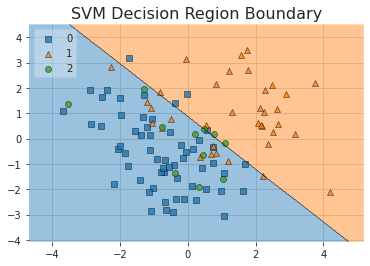

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)  #Bringing down number of features to two using PCA for plotting boundary
X_train2 = pca.fit_transform(X_train)
clf.fit(X_train2, y_train)
plot_decision_regions(X_train2, y_train.to_numpy().reshape(106), clf=clf, legend=2)

plt.title('SVM Decision Region Boundary', size=16);

#### Confusion matrix for multi-class classification

* Predict the test and plot the confusion matrix

In [ ]:
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))

[[13  0  0]
 [ 0 17  3]
 [ 0  0  3]]


In [ ]:
y_test.shape

(36, 1)

In [ ]:
y_test.value_counts()

Group
1        20
0        13
2         3
dtype: int64

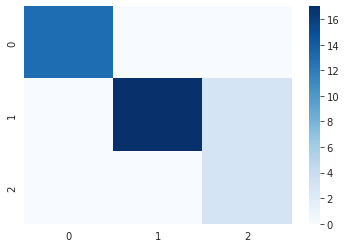

In [ ]:
sns.heatmap(cm, fmt='', cmap='Blues')

Comment:  The first row are the actual Nondemented subjects. The model predicted 13 of these correctly and incorrectly predicted 0 of the Nondemented subjects to be Demented and 0 of the Nondemented subjects to be Converted.

Looking at the Nondemented column, of the 13 Nondemented subjects predicted by the model (sum of column 0), 13 were actually Nondemented subjects, while 0 were Demented subjects incorrectly predicted to be Nondemented subjects and 0 were Converted subjects incorrectly predicted to be Nondemented subjects.

#### One VS Rest Classifier

OneVsRestClassifier can also be used for multilabel classification. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed)

* Fit `OneVsRestClassifier` on the data and find the accuracy

Hint: [OneVsRestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html)

In [ ]:
# YOUR CODE HERE
clf1 = OneVsRestClassifier(SVC(kernel='linear')).fit(X_train, y_train)

In [ ]:
y_pred1 = clf1.predict(X_test)
acc_ovr = accuracy_score(y_test, y_pred1)
print(acc_ovr)

0.9166666666666666


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


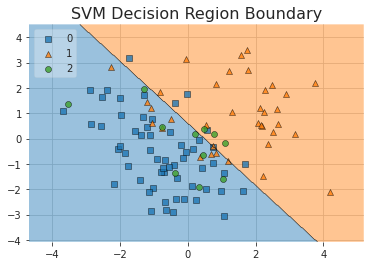

In [ ]:
clf1.fit(X_train2, y_train)
plot_decision_regions(X_train2, y_train.to_numpy().reshape(106), clf=clf1, legend=2)

plt.title('SVM Decision Region Boundary', size=16);

#### One VS One Classifier

This strategy consists of fitting one classifier per class pair. At prediction time, the class which received the most votes is selected.

* Fit `OneVsOneClassifier` on the data and find the accuracy

Hint: [OneVsOneClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html)

In [ ]:
# YOUR CODE HERE
clf2 = OneVsOneClassifier(SVC(kernel='linear')).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
y_pred2 = clf2.predict(X_test)
acc_ovo = accuracy_score(y_test, y_pred2)
print(acc_ovo)

0.9166666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


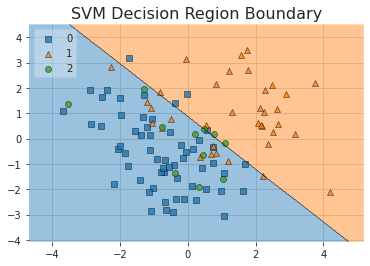

In [ ]:
clf2.fit(X_train2, y_train)
plot_decision_regions(X_train2, y_train.to_numpy().reshape(106), clf=clf2, legend=2)

plt.title('SVM Decision Region Boundary', size=16);

#### Change target labels to a binary classification form

As stated in the dataset description, 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit. Change `Converted` label into `Demented`.

**Note:** In two-class classification, encode the labels into numerical to plot the roc_curve with predictions.

In [ ]:
y1 = y.copy()
y1['Group']=y.Group.apply(lambda x:1 if(x==2) else x)
y1.Group

1      0
6      0
9      0
14     0
16     1
      ..
355    1
364    0
366    1
369    1
372    0
Name: Group, Length: 142, dtype: int64

In [ ]:
# YOUR CODE HERE
X_train1, X_test1, y_train1, y_test1 = train_test_split(processed_data, y1.Group, test_size=0.25, random_state=42,)
clf3 = SVC(kernel='linear')
clf3.fit(X_train1, y_train1)
y_pred3 = clf3.predict(X_test1)
print(accuracy_score(y_test1, y_pred3))

1.0


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


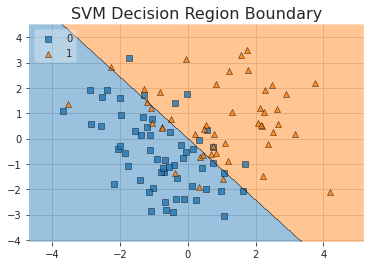

In [ ]:
pca1 = PCA(n_components = 2)
X_train3 = pca1.fit_transform(X_train1)
clf3.fit(X_train3, y_train1)
plot_decision_regions(X_train3, y_train1.to_numpy().reshape(106), clf=clf3, legend=2)

plt.title('SVM Decision Region Boundary', size=16);

In [ ]:
confusion_matrix(y_test1, y_pred3)

array([[13,  0],
       [ 0, 23]])

#### Compare the performance and predictions of both multi-class and binary classifications

In [ ]:
# YOUR CODE HERE
print(confusion_matrix(y_test, y_pred))
print(confusion_matrix(y_test1, y_pred3))

[[13  0  0]
 [ 0 17  3]
 [ 0  0  3]]
[[13  0]
 [ 0 23]]


### Classification report and metrics (2 points)

In [ ]:
from sklearn.metrics import classification_report

#Multilabel classification
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.85      0.92        20
           2       0.50      1.00      0.67         3

    accuracy                           0.92        36
   macro avg       0.83      0.95      0.86        36
weighted avg       0.96      0.92      0.93        36



In [ ]:
#Binary classification
print(classification_report(y_test1, y_pred3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        23

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



#### Confusion matrix

Describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

In [ ]:
# YOUR CODE HERE
print(confusion_matrix(y_test, y_pred))
print(confusion_matrix(y_test1, y_pred3))

[[13  0  0]
 [ 0 17  3]
 [ 0  0  3]]
[[13  0]
 [ 0 23]]


#### Plot the ROC Curve

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

In [ ]:
# YOUR CODE HERE
from sklearn.metrics import plot_roc_curve

plot_roc_curve(clf3, X_test1, y_test1);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


ValueError: ignored

### Choice of C for SVM (1 point)

experiment with different C values given and plot the ROC curve for each

In [ ]:
c_val = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
# YOUR CODE HERE
for c in c_val:
    clf4 = SVC(kernel='linear', C=c)
    clf4.fit(X_train1, y_train1)
    y_pred4 = clf4.predict(X_test1)
    print(c, accuracy_score(y_test1, y_pred4))

0.0001 0.3611111111111111
0.001 0.3611111111111111
0.01 0.6388888888888888
0.1 1.0
1 1.0
10 1.0
100 1.0
1000 1.0


### Report Analysis

* Compare the performance of the model with various Kernel parameters.
* Discuss the impact of parameter C and gamma on performance.
* Comment on the computational cost of implementing one vs one and one vs all to solve multi-class classification with binary classifier.
* When do you call a sample/record in the data as a support vector?